In [ ]:
# importing necessary modules

import pandas as pd
import numpy as np

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Get Features data from compressed file

In [ ]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_x.npz')
# extract the first array
X = dict_data['arr_0']
# print the array
print(X)

[[ 7.61570786e-02  6.56093121e-01  6.97486043e-01 ... -5.49116870e-02
   8.43622550e-03  8.68360564e-03]
 [ 3.08421125e-01  7.74146830e-01  7.84921267e-01 ... -5.32998237e-02
   6.42975885e-03  6.52271166e-04]
 [ 8.72673717e-02  6.54679716e-01  7.06031144e-01 ... -4.93619013e-02
   1.00196785e-02 -1.45468115e-02]
 ...
 [ 4.21099154e-02  6.06974602e-01  6.26703024e-01 ... -8.72499610e-03
  -2.71237992e-04  8.32928067e-03]
 [ 7.67161252e-02  6.64062593e-01  7.05808759e-01 ... -1.18949142e-02
   1.34713884e-03  1.00048997e-02]
 [ 4.00004327e-02  5.26626468e-01  5.81800938e-01 ... -1.05777125e-02
   1.77729089e-02  6.90816244e-03]]


In [ ]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_y.npz')
# extract the first array
Y = dict_data['arr_0']
# print the array
print(Y)

['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [ ]:
X.shape, Y.shape

((36621, 168), (36621,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y

Features.shapeFeatures = pd.DataFrame(X)
Features['labels'] = Y

Features.shape

(36621, 169)

In [ ]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,labels
0,0.076157,0.656093,0.697486,0.684813,0.680425,0.670918,0.575612,0.571766,0.629165,0.661047,...,6.605648e-14,6.174020e-14,6.174255e-14,0.011220,0.014544,-0.039381,-0.054912,0.008436,0.008684,angry
1,0.308421,0.774147,0.784921,0.809351,0.821838,0.844925,0.699101,0.638095,0.689210,0.690306,...,7.761280e-03,7.527370e-03,7.440646e-03,0.012350,0.008338,-0.010212,-0.053300,0.006430,0.000652,angry
2,0.087267,0.654680,0.706031,0.680971,0.661931,0.663260,0.589141,0.585150,0.644148,0.674946,...,7.714200e-10,8.551017e-10,8.551819e-10,-0.034502,-0.012042,0.038216,-0.049362,0.010020,-0.014547,angry
3,0.068002,0.714656,0.741048,0.658524,0.676285,0.686411,0.614934,0.584842,0.618500,0.691588,...,7.580490e-11,7.497029e-11,7.442415e-11,-0.008231,-0.019454,-0.039172,-0.033343,0.011401,0.004871,disgust
4,0.186074,0.815682,0.790408,0.783426,0.828106,0.775787,0.670662,0.662607,0.709455,0.764102,...,5.412507e-04,5.651963e-04,5.830280e-04,-0.016078,-0.019964,-0.027505,-0.043751,0.013713,-0.002633,disgust


## Model Training and Testing

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27465, 168), (27465, 8), (9156, 168), (9156, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27465, 168), (27465, 8), (9156, 168), (9156, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27465, 168, 1), (27465, 8), (9156, 168, 1), (9156, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 84, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
430/430 [==============================] - 91s 203ms/step - loss: 1.7297 - accuracy: 0.2954 - val_loss: 1.4735 - val_accuracy: 0.3960 - lr: 0.0010
Epoch 2/50
430/430 [==============================] - 80s 186ms/step - loss: 1.4737 - accuracy: 0.4014 - val_loss: 1.3628 - val_accuracy: 0.4404 - lr: 0.0010
Epoch 3/50
430/430 [==============================] - 80s 186ms/step - loss: 1.3759 - accuracy: 0.4409 - val_loss: 1.2756 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 4/50
430/430 [==============================] - 77s 180ms/step - loss: 1.3137 - accuracy: 0.4663 - val_loss: 1.2355 - val_accuracy: 0.4818 - lr: 0.0010
Epoch 5/50
430/430 [==============================] - 80s 185ms/step - loss: 1.2696 - accuracy: 0.4831 - val_loss: 1.2196 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 6/50
430/430 [==============================] - 81s 189ms/step - loss: 1.2424 - accuracy: 0.4965 - val_loss: 1.1976 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 7/50
430/430 [==============================] 

In [ ]:
import joblib
model_filename = "lstm.pkl"
joblib.dump(history.history, model_filename)

['lstm.pkl']

287/287 [==============================] - 7s 23ms/step - loss: 1.1358 - accuracy: 0.6117
Accuracy of our model on test data :  61.173003911972046 %


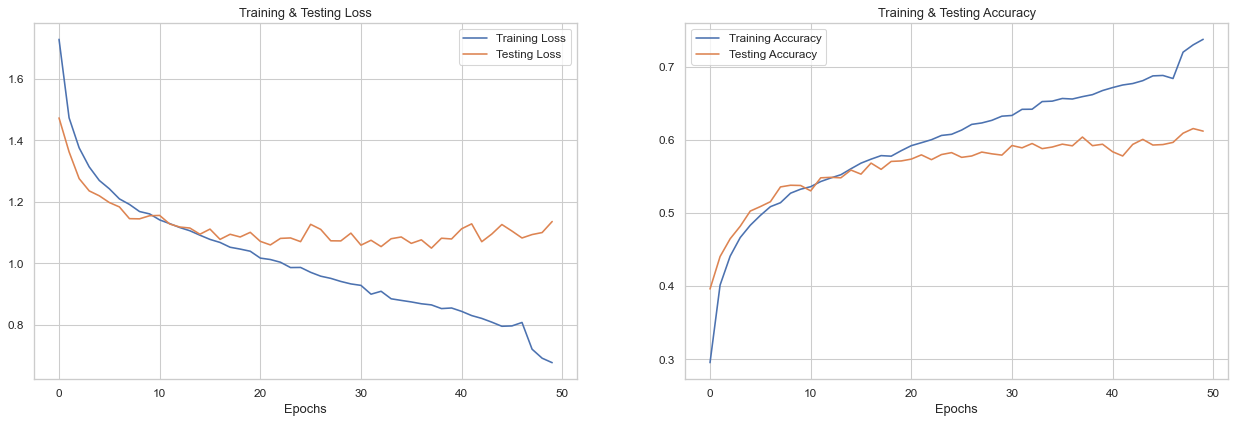

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

287/287 [==============================] - 8s 20ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,neutral
1,surprise,surprise
2,disgust,disgust
3,angry,angry
4,disgust,disgust
5,sad,disgust
6,angry,angry
7,disgust,disgust
8,sad,disgust
9,sad,sad


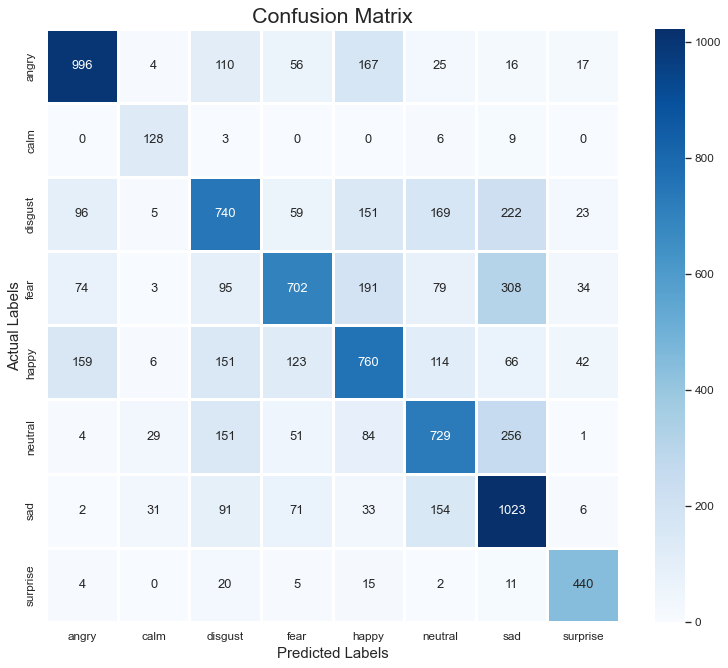

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.77      0.74      0.75      1418
        calm       0.59      0.84      0.69       149
     disgust       0.54      0.52      0.53      1469
        fear       0.67      0.48      0.56      1462
       happy       0.55      0.55      0.55      1482
     neutral       0.53      0.62      0.57      1307
         sad       0.57      0.68      0.62      1385
    surprise       0.85      0.83      0.84       484

    accuracy                           0.61      9156
   macro avg       0.63      0.66      0.64      9156
weighted avg       0.62      0.61      0.61      9156

